# CQF - Exam 2

### Imports

In [283]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

Parameters

In [201]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 200
dt = T / N
ts = np.arange(0, T, dt)
dB = np.random.randn(N) * np.sqrt(dt)
B = np.cumsum(dB)

### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

<AxesSubplot:>

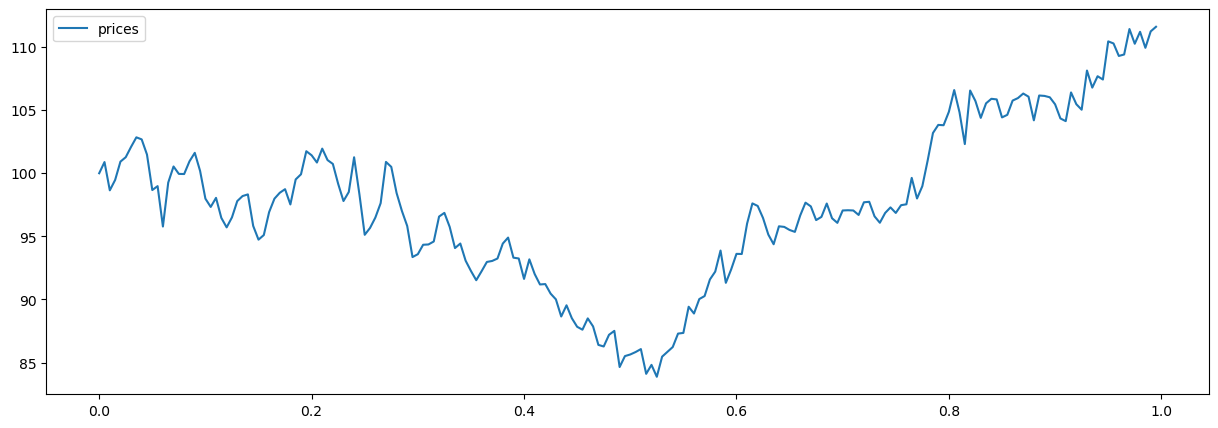

In [218]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

em_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
em_df.plot(colormap='tab10', figsize=[15,5])

### Milstein schema

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

<AxesSubplot:>

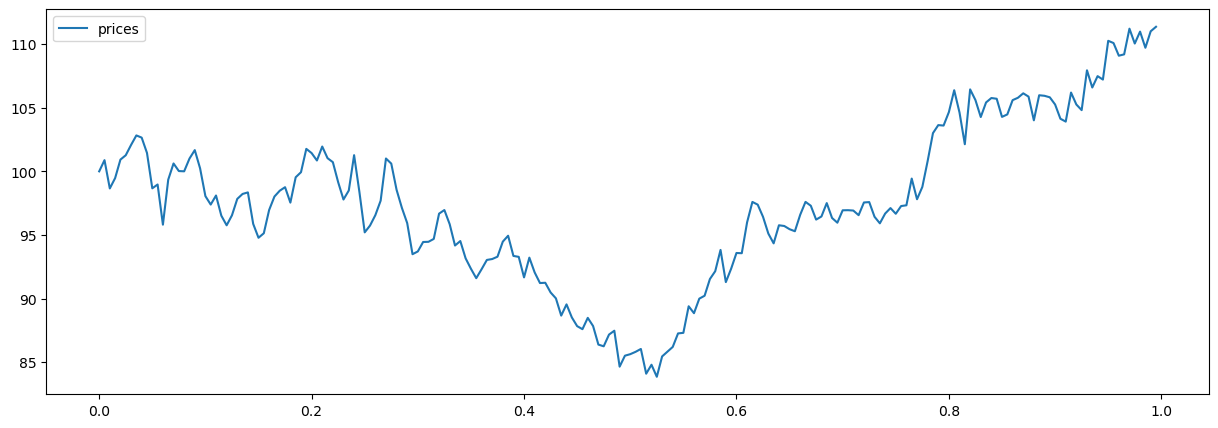

In [217]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
        + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

milstein_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
milstein_df.plot(colormap='tab10', figsize=[15,5])

### Closed Form Solution

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t))}
$$

<AxesSubplot:>

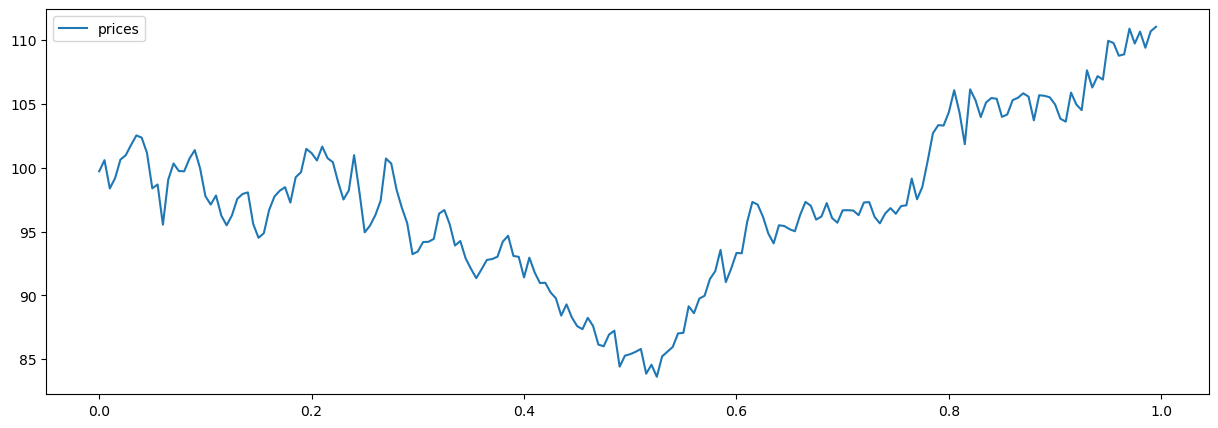

In [216]:
S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
closed_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
closed_df.plot(colormap='tab10', figsize=[15,5])

<AxesSubplot:>

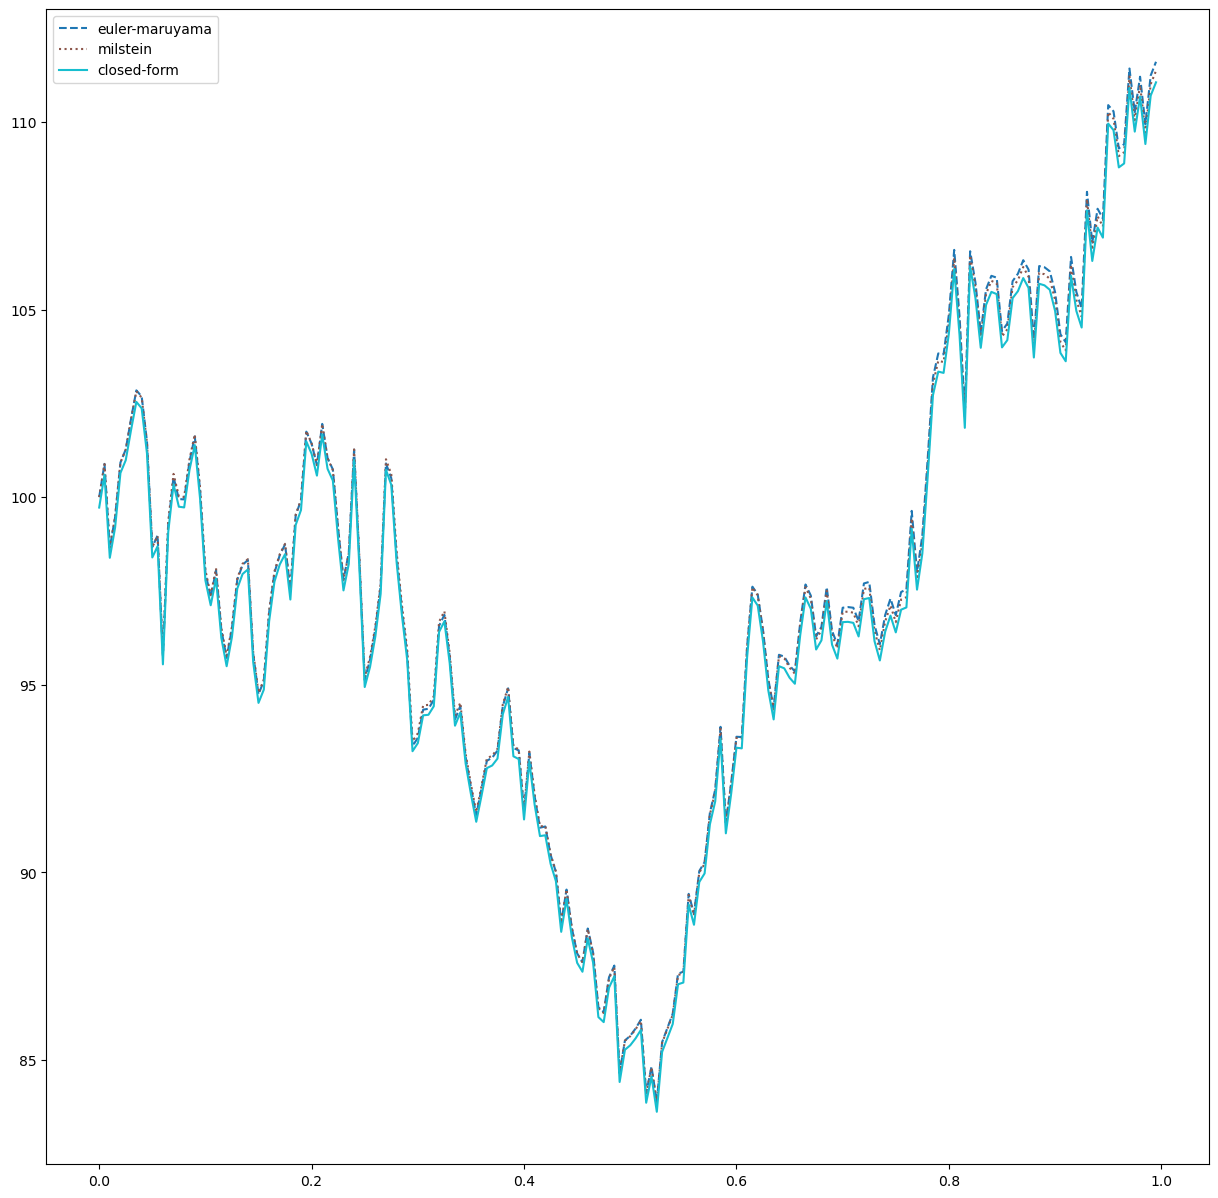

In [219]:
compare_df = em_df.copy()
compare_df.columns = ['euler-maruyama']

compare_df['milstein'] = milstein_df['prices']
compare_df['closed-form'] = closed_df['prices']
compare_df.plot(style=['--', ':', '-'],colormap='tab10', figsize=[15,15])

### Payoffs

In [293]:
n_simul = 10000
simulations = [np.random.randn(N) * np.sqrt(dt) for i in range(n_simul)]

euler_paths = [] 
milstein_paths = [] 
close_paths = []

for s in simulations:
    B = np.cumsum(s)
    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i]

    euler_paths.append(S)

    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i] \
            + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

    milstein_paths.append(S)

    S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
    close_paths.append(S)

In [294]:
def vanilla_payoff(S, K, CP):
    return max(S[-1]-K, 0) if CP == 'C' else max(K-S[-1], 0)

def asian_payoff(S, K, CP, avg_func, fixed_strike=True):
    if CP == 'C':
        return max(avg_func(S)-K, 0) if fixed_strike else max(S[-1]-avg_func(S), 0)
    else:
        return max(K-avg_func(S), 0) if fixed_strike else max(avg_func(S)-S[-1], 0)
    
E = 100

df = pd.DataFrame(index=['euler-maruyama','milstein', 'closed'], data=[
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in euler_paths]), 
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in euler_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in milstein_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in close_paths])
    ]],
    columns=['call mean fixed strike', 'put mean fixed strike', 'call mean float strie', 'put mean float strike', 'call gmean fixed strike', 'put gmean fixed strike', 'call gmean float strike', 'put gmean float strike'])

df

,call mean fixed strike,put mean fixed strike,call mean float strie,put mean float strike,call gmean fixed strike,put gmean fixed strike,call gmean float strike,put gmean float strike
euler-maruyama,5.819083,3.320268,5.777377,3.454276,5.600962,3.436155,5.986131,3.329022
milstein,5.789634,3.336850,5.675220,3.520833,5.574057,3.454018,5.880289,3.393157
closed,5.850571,3.353316,5.775892,3.454127,5.632819,3.469654,5.984825,3.328970


In [296]:
ts

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

### Question 3 - Monte Carlo Integration

Define function for Monte Carlo integration

In [8]:
def monte_carlo_integration(func, N, limit_inf, limit_sup):
    xs = np.random.uniform(limit_inf, limit_sup, size=N)
    ys = [func(x) for x in xs]
    return (limit_sup - limit_inf) / N * np.sum(ys)

I.
$$
\int_{1}^{3}x^2dx = \frac{1}{3}x^3\Biggr|_{1}^{3} =  \frac{26}{3} = 8.666667
$$

In [64]:
def func(x):
    return x**2

exact_value = 8.666667
limit_inf = 1
limit_sup = 3

In [65]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,8.666667,9.614810,-0.948143
20,8.666667,8.703844,-0.037177
40,8.666667,9.495301,-0.828634
80,8.666667,7.905635,0.761032
160,8.666667,8.586028,0.080639
320,8.666667,9.038057,-0.371390
640,8.666667,8.839121,-0.172454
1280,8.666667,8.726455,-0.059788
2560,8.666667,8.695698,-0.029031
5120,8.666667,8.581539,0.085128


Text(0, 0.5, 'error')

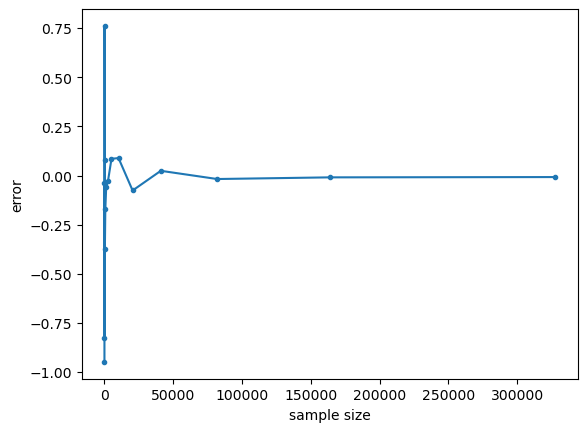

In [66]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

II.
$$
\int_{0}^{\infty}e^{-x^2}dx = \frac{1}{2}\sqrt\pi \text{erf} (x) \approx 0.886227
$$

In [73]:
def func(x):
    return np.exp(-x**2)

exact_value = 0.886227
limit_inf = 0
limit_sup = 500

In [74]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,0.886227,0.000000e+00,0.886227
20,0.886227,1.017382e-101,0.886227
40,0.886227,9.753709e-265,0.886227
80,0.886227,1.881684e-04,0.886039
160,0.886227,2.021902e-01,0.684037
320,0.886227,1.174664e+00,-0.288437
640,0.886227,7.851220e-01,0.101105
1280,0.886227,1.333041e+00,-0.446814
2560,0.886227,6.127490e-01,0.273478
5120,0.886227,8.027067e-01,0.083520


Text(0, 0.5, 'error')

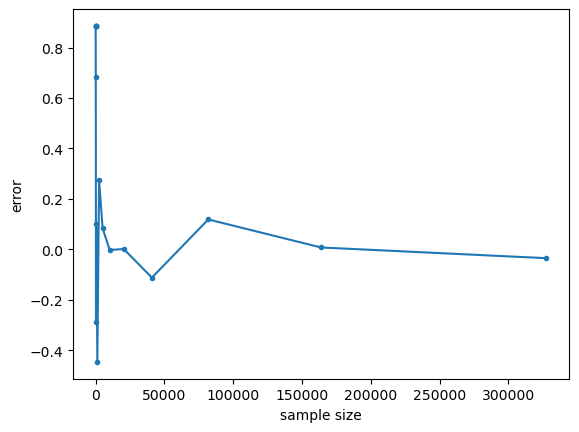

In [75]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

III.

$$
\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x^{4}e^{-x^2/2}dx = 0.398942 \left( 3\sqrt{\frac{\pi}{2}} \text{erf} \left(\frac{x}{\sqrt{2}}\right) - e^{-x^2/2} x ( x^2 + 3) \right) = 3
$$

In [76]:
def func(x):
    return ( 1.0 / np.sqrt(2*np.pi) ) * x**4 * np.exp(-x**2 / 2)

exact_value = 3.
limit_inf = -500
limit_sup = 500

In [77]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,3.0,4.915361e+01,-46.153614
20,3.0,7.358982e-55,3.000000
40,3.0,2.106291e+01,-18.062909
80,3.0,1.505505e+00,1.494495
160,3.0,1.097595e-02,2.989024
320,3.0,1.697491e+00,1.302509
640,3.0,1.353283e+00,1.646717
1280,3.0,2.851968e+00,0.148032
2560,3.0,3.758549e+00,-0.758549
5120,3.0,3.413088e+00,-0.413088


Text(0, 0.5, 'error')

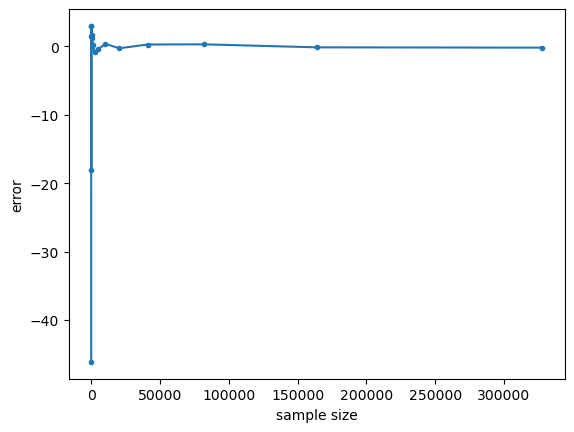

In [78]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')